<a href="https://colab.research.google.com/github/MMoronto/pytorch_exercises/blob/master/Peutingar_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Data Dictionary

In [1]:
pip install pytorch-forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.4/141.4 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.8/827.8 KB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.2/308.2 KB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 75.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.2/147.2 KB 22.9 MB/s eta 0:00:00
     ━━━━━━━━

##Load data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

path1='/content/drive/MyDrive/Colab Notebooks/infra_data/Salient_cement_stats.xls'
path2='/content/drive/MyDrive/Colab Notebooks/infra_data/Salient_cement_stats.csv'
fob=open(path2,)
headings=next(fob)
for rec in fob:
  Cement3=rec.split(',')
  print(Cement3)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['"SALIENT CEMENT STATISTICS1', ' 2 "', '', '', '', '', '', '', '\n']
['', '', '', '', '', '', '', '\n']
['(Thousand metric tons unless otherwise specified)', '', '', '', '', '', '', '\n']
['', '', '', '', '', '', '', '\n']
['', '', '', '2014', '2015', '2016', '2017', '2018\n']
['United States:', '', '', '', '', '', '', '\n']
['Production:', '', '', '', '', '', '', '\n']
['Cement3', '', '', '"82', '535"', '"84', '405"', '"84', '695"', '"86', '356"', '"86', '400"\n']
['Clinker', '', '', '"74', '372"', '"76', '043"', '"75', '633"', '"76', '678"', '"77', '112"\n']
['"Shipments from mills and terminals:3', ' 4"', '', '', '', '', '', '', '\n']
['Quantity', '', '', '"88', '900"', '"92', '000"', '"94', '300"', '"96', '900"', '"98', '500"\n']
['Value5', 'thousand dollars', '', '"8', '940', '000"', '"9', '800', '000"', '"10', '500', '000"', '"11', '300', '000"', '"11'

In [3]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

os.chdir("../../..")

import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters


In [4]:
# Create a series and let pandas create a default integer index:
s = pd.Series([1, 3, 5, np.nan, 6, 8])
s

0    1.0
1    3.0
2    5.0
3    NaN
4    6.0
5    8.0
dtype: float64

In [5]:
from pandas.io.stata import DatetimeIndex
# Create a DataFrame by passing a NumPy array with a dateline index using `date_range()` & labeled columns:
dates = pd.date_range("20230101", periods=8)

dates

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05', '2023-01-06'], dtype='datetime64[ns]', freq='D')

df = pd.DataFrame(np.random.randn(8, 6), index=dates, columns=list("ABCDEF"))

df 

,A,B,C,D,E,F
2023-01-01,0.448277,0.430838,0.363255,-0.993682,1.352389,-0.126001
2023-01-02,1.298214,0.108480,-0.206445,-0.851700,0.044227,-0.176283
2023-01-03,0.976906,-1.900116,-4.069443,0.642765,-0.523424,0.165216
2023-01-04,0.720061,-0.804913,-0.762555,-0.940518,-0.634364,-0.022617
2023-01-05,0.424403,0.912782,0.622643,-1.786721,0.640651,-0.380659
2023-01-06,-0.864181,0.143002,-0.082958,-0.469248,1.126404,-1.112964
2023-01-07,0.626625,-0.991663,-0.392851,-0.672656,-0.979711,0.548689
2023-01-08,-0.200741,0.624610,-0.651291,0.757509,1.624665,-0.305613


In [6]:
# Create a `DataFrame` by passing a dictionary of objects that can be converted into a series-like structure:

df2 = pd.DataFrame(
    {
        "A": 1.0,
        "B": pd.Timestamp("20230102"),
        "C": pd.Series(1, index=list(range(4)), dtype="float32"),
        "D": np.array([3] * 4, dtype="int32"),
        "E": pd.Categorical(["test", "train", "test", "train"]),
        "F": "foo",
    }
)

df2

,A,B,C,D,E,F
0,1.0,2023-01-02,1.0,3,test,foo
1,1.0,2023-01-02,1.0,3,train,foo
2,1.0,2023-01-02,1.0,3,test,foo
3,1.0,2023-01-02,1.0,3,train,foo


In [7]:
df2.dtypes

A           float64
B    datetime64[ns]
C           float32
D             int32
E          category
F            object
dtype: object

In [8]:
df2.D

0    3
1    3
2    3
3    3
Name: D, dtype: int32

##Viewing data

In [9]:
df.head()

,A,B,C,D,E,F
2023-01-01,0.448277,0.430838,0.363255,-0.993682,1.352389,-0.126001
2023-01-02,1.298214,0.108480,-0.206445,-0.851700,0.044227,-0.176283
2023-01-03,0.976906,-1.900116,-4.069443,0.642765,-0.523424,0.165216
2023-01-04,0.720061,-0.804913,-0.762555,-0.940518,-0.634364,-0.022617
2023-01-05,0.424403,0.912782,0.622643,-1.786721,0.640651,-0.380659


In [10]:
df.tail()

,A,B,C,D,E,F
2023-01-04,0.720061,-0.804913,-0.762555,-0.940518,-0.634364,-0.022617
2023-01-05,0.424403,0.912782,0.622643,-1.786721,0.640651,-0.380659
2023-01-06,-0.864181,0.143002,-0.082958,-0.469248,1.126404,-1.112964
2023-01-07,0.626625,-0.991663,-0.392851,-0.672656,-0.979711,0.548689
2023-01-08,-0.200741,0.624610,-0.651291,0.757509,1.624665,-0.305613


In [11]:
df.columns

Index(['A', 'B', 'C', 'D', 'E', 'F'], dtype='object')

In [12]:
df.index

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04',
               '2023-01-05', '2023-01-06', '2023-01-07', '2023-01-08'],
              dtype='datetime64[ns]', freq='D')

`DataFrame.to_numpy()` gives a NumPy representation of the underlying data. 

In [13]:
df.to_numpy()

array([[ 0.44827742,  0.43083781,  0.3632552 , -0.99368171,  1.35238905,
        -0.1260005 ],
       [ 1.29821398,  0.10848048, -0.206445  , -0.85170025,  0.04422729,
        -0.1762835 ],
       [ 0.97690621, -1.9001159 , -4.06944288,  0.64276473, -0.5234241 ,
         0.16521565],
       [ 0.72006127, -0.80491302, -0.76255531, -0.94051785, -0.63436357,
        -0.0226171 ],
       [ 0.4244028 ,  0.91278164,  0.62264256, -1.78672143,  0.64065126,
        -0.38065933],
       [-0.86418052,  0.14300193, -0.08295841, -0.46924776,  1.12640358,
        -1.11296416],
       [ 0.62662525, -0.99166347, -0.39285141, -0.67265581, -0.97971086,
         0.54868886],
       [-0.20074117,  0.62460996, -0.6512911 ,  0.7575087 ,  1.62466534,
        -0.305613  ]])

In [14]:
df2.to_numpy()

array([[1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'test', 'foo'],
       [1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'train', 'foo'],
       [1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'test', 'foo'],
       [1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'train', 'foo']],
      dtype=object)

In [15]:
df.describe()

,A,B,C,D,E,F
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,0.428696,-0.184623,-0.647456,-0.539281,0.331355,-0.176279
std,0.681258,0.956943,1.460720,0.855468,0.993373,0.478721
min,-0.864181,-1.900116,-4.069443,-1.786721,-0.979711,-1.112964
25%,0.268117,-0.851601,-0.679107,-0.953809,-0.551159,-0.324375
50%,0.537451,0.125741,-0.299648,-0.762178,0.342439,-0.151142
75%,0.784273,0.479281,0.028595,-0.191245,1.182900,0.024341
max,1.298214,0.912782,0.622643,0.757509,1.624665,0.548689


In [16]:
df

,A,B,C,D,E,F
2023-01-01,0.448277,0.430838,0.363255,-0.993682,1.352389,-0.126001
2023-01-02,1.298214,0.108480,-0.206445,-0.851700,0.044227,-0.176283
2023-01-03,0.976906,-1.900116,-4.069443,0.642765,-0.523424,0.165216
2023-01-04,0.720061,-0.804913,-0.762555,-0.940518,-0.634364,-0.022617
2023-01-05,0.424403,0.912782,0.622643,-1.786721,0.640651,-0.380659
2023-01-06,-0.864181,0.143002,-0.082958,-0.469248,1.126404,-1.112964
2023-01-07,0.626625,-0.991663,-0.392851,-0.672656,-0.979711,0.548689
2023-01-08,-0.200741,0.624610,-0.651291,0.757509,1.624665,-0.305613


In [17]:
df.T

,2023-01-01,2023-01-02,2023-01-03,2023-01-04,2023-01-05,2023-01-06,2023-01-07,2023-01-08
A,0.448277,1.298214,0.976906,0.720061,0.424403,-0.864181,0.626625,-0.200741
B,0.430838,0.108480,-1.900116,-0.804913,0.912782,0.143002,-0.991663,0.624610
C,0.363255,-0.206445,-4.069443,-0.762555,0.622643,-0.082958,-0.392851,-0.651291
D,-0.993682,-0.851700,0.642765,-0.940518,-1.786721,-0.469248,-0.672656,0.757509
E,1.352389,0.044227,-0.523424,-0.634364,0.640651,1.126404,-0.979711,1.624665
F,-0.126001,-0.176283,0.165216,-0.022617,-0.380659,-1.112964,0.548689,-0.305613


In [18]:
df.sort_index(axis=1, ascending=False)

,F,E,D,C,B,A
2023-01-01,-0.126001,1.352389,-0.993682,0.363255,0.430838,0.448277
2023-01-02,-0.176283,0.044227,-0.851700,-0.206445,0.108480,1.298214
2023-01-03,0.165216,-0.523424,0.642765,-4.069443,-1.900116,0.976906
2023-01-04,-0.022617,-0.634364,-0.940518,-0.762555,-0.804913,0.720061
2023-01-05,-0.380659,0.640651,-1.786721,0.622643,0.912782,0.424403
2023-01-06,-1.112964,1.126404,-0.469248,-0.082958,0.143002,-0.864181
2023-01-07,0.548689,-0.979711,-0.672656,-0.392851,-0.991663,0.626625
2023-01-08,-0.305613,1.624665,0.757509,-0.651291,0.624610,-0.200741


In [19]:
df.sort_values(by="B")

,A,B,C,D,E,F
2023-01-03,0.976906,-1.900116,-4.069443,0.642765,-0.523424,0.165216
2023-01-07,0.626625,-0.991663,-0.392851,-0.672656,-0.979711,0.548689
2023-01-04,0.720061,-0.804913,-0.762555,-0.940518,-0.634364,-0.022617
2023-01-02,1.298214,0.108480,-0.206445,-0.851700,0.044227,-0.176283
2023-01-06,-0.864181,0.143002,-0.082958,-0.469248,1.126404,-1.112964
2023-01-01,0.448277,0.430838,0.363255,-0.993682,1.352389,-0.126001
2023-01-08,-0.200741,0.624610,-0.651291,0.757509,1.624665,-0.305613
2023-01-05,0.424403,0.912782,0.622643,-1.786721,0.640651,-0.380659


In [20]:
df

,A,B,C,D,E,F
2023-01-01,0.448277,0.430838,0.363255,-0.993682,1.352389,-0.126001
2023-01-02,1.298214,0.108480,-0.206445,-0.851700,0.044227,-0.176283
2023-01-03,0.976906,-1.900116,-4.069443,0.642765,-0.523424,0.165216
2023-01-04,0.720061,-0.804913,-0.762555,-0.940518,-0.634364,-0.022617
2023-01-05,0.424403,0.912782,0.622643,-1.786721,0.640651,-0.380659
2023-01-06,-0.864181,0.143002,-0.082958,-0.469248,1.126404,-1.112964
2023-01-07,0.626625,-0.991663,-0.392851,-0.672656,-0.979711,0.548689
2023-01-08,-0.200741,0.624610,-0.651291,0.757509,1.624665,-0.305613


##Getting

In [21]:
# Select a single column, which yields a Series, equivalent to 'df.A'
df["A"]

2023-01-01    0.448277
2023-01-02    1.298214
2023-01-03    0.976906
2023-01-04    0.720061
2023-01-05    0.424403
2023-01-06   -0.864181
2023-01-07    0.626625
2023-01-08   -0.200741
Freq: D, Name: A, dtype: float64

Selecting via `[]` `(__getitem__)`, which slices the rows:

In [22]:
df[0:3]

,A,B,C,D,E,F
2023-01-01,0.448277,0.430838,0.363255,-0.993682,1.352389,-0.126001
2023-01-02,1.298214,0.108480,-0.206445,-0.851700,0.044227,-0.176283
2023-01-03,0.976906,-1.900116,-4.069443,0.642765,-0.523424,0.165216


In [23]:
df["20230102":"20230104"]

,A,B,C,D,E,F
2023-01-02,1.298214,0.108480,-0.206445,-0.851700,0.044227,-0.176283
2023-01-03,0.976906,-1.900116,-4.069443,0.642765,-0.523424,0.165216
2023-01-04,0.720061,-0.804913,-0.762555,-0.940518,-0.634364,-0.022617


In [24]:
df

,A,B,C,D,E,F
2023-01-01,0.448277,0.430838,0.363255,-0.993682,1.352389,-0.126001
2023-01-02,1.298214,0.108480,-0.206445,-0.851700,0.044227,-0.176283
2023-01-03,0.976906,-1.900116,-4.069443,0.642765,-0.523424,0.165216
2023-01-04,0.720061,-0.804913,-0.762555,-0.940518,-0.634364,-0.022617
2023-01-05,0.424403,0.912782,0.622643,-1.786721,0.640651,-0.380659
2023-01-06,-0.864181,0.143002,-0.082958,-0.469248,1.126404,-1.112964
2023-01-07,0.626625,-0.991663,-0.392851,-0.672656,-0.979711,0.548689
2023-01-08,-0.200741,0.624610,-0.651291,0.757509,1.624665,-0.305613


##Selection by label

In [25]:
df.loc[dates[1]]

A    1.298214
B    0.108480
C   -0.206445
D   -0.851700
E    0.044227
F   -0.176283
Name: 2023-01-02 00:00:00, dtype: float64

In [26]:
#Selecting on a multi-axis by label:
df.loc[:, ["A", "D"]]

,A,D
2023-01-01,0.448277,-0.993682
2023-01-02,1.298214,-0.851700
2023-01-03,0.976906,0.642765
2023-01-04,0.720061,-0.940518
2023-01-05,0.424403,-1.786721
2023-01-06,-0.864181,-0.469248
2023-01-07,0.626625,-0.672656
2023-01-08,-0.200741,0.757509


In [27]:
# Showing label slicing, both endpoints are included:
df.loc["20230104":"20230106", ["A", "D"]]

,A,D
2023-01-04,0.720061,-0.940518
2023-01-05,0.424403,-1.786721
2023-01-06,-0.864181,-0.469248


In [28]:
# Reduction in the dimensions of the returned object:
df.loc["20230104", ["A", "D"]]

A    0.720061
D   -0.940518
Name: 2023-01-04 00:00:00, dtype: float64

In [29]:
# For getting a scalar value
df.loc[dates[1], "D"]

-0.8517002469755331

In [30]:
# For getting fast access to a scalar value
df.at[dates[1], "D"]

-0.8517002469755331

##Selection by position

In [31]:
df.iloc[3]

A    0.720061
B   -0.804913
C   -0.762555
D   -0.940518
E   -0.634364
F   -0.022617
Name: 2023-01-04 00:00:00, dtype: float64

In [32]:
df.iloc[3:5, 0:2]

,A,B
2023-01-04,0.720061,-0.804913
2023-01-05,0.424403,0.912782


In [33]:
df.iloc[[1, 2, 4], [0, 2]]

,A,C
2023-01-02,1.298214,-0.206445
2023-01-03,0.976906,-4.069443
2023-01-05,0.424403,0.622643


In [34]:
# For slicing rows explicitly
df.iloc[1:3, :]

,A,B,C,D,E,F
2023-01-02,1.298214,0.108480,-0.206445,-0.851700,0.044227,-0.176283
2023-01-03,0.976906,-1.900116,-4.069443,0.642765,-0.523424,0.165216


In [35]:
# For slicing columns explicitly
df.iloc[:, 1:3]

,B,C
2023-01-01,0.430838,0.363255
2023-01-02,0.108480,-0.206445
2023-01-03,-1.900116,-4.069443
2023-01-04,-0.804913,-0.762555
2023-01-05,0.912782,0.622643
2023-01-06,0.143002,-0.082958
2023-01-07,-0.991663,-0.392851
2023-01-08,0.624610,-0.651291


In [36]:
# For getting values explicitly
df.iloc[1, 1]

0.10848048133403089

In [37]:
# For getting fast access to scalar (equivalent to the prior method)
df.iat[1, 1]

0.10848048133403089

## Boolean indexing
Using a single column's values to select data:

In [38]:
df[df["A"] > 0]

,A,B,C,D,E,F
2023-01-01,0.448277,0.430838,0.363255,-0.993682,1.352389,-0.126001
2023-01-02,1.298214,0.108480,-0.206445,-0.851700,0.044227,-0.176283
2023-01-03,0.976906,-1.900116,-4.069443,0.642765,-0.523424,0.165216
2023-01-04,0.720061,-0.804913,-0.762555,-0.940518,-0.634364,-0.022617
2023-01-05,0.424403,0.912782,0.622643,-1.786721,0.640651,-0.380659
2023-01-07,0.626625,-0.991663,-0.392851,-0.672656,-0.979711,0.548689


In [39]:
# Selecting values from a DataFrame where a boolean condition is met:
df[df > 0]

,A,B,C,D,E,F
2023-01-01,0.448277,0.430838,0.363255,NaN,1.352389,NaN
2023-01-02,1.298214,0.108480,NaN,NaN,0.044227,NaN
2023-01-03,0.976906,NaN,NaN,0.642765,NaN,0.165216
2023-01-04,0.720061,NaN,NaN,NaN,NaN,NaN
2023-01-05,0.424403,0.912782,0.622643,NaN,0.640651,NaN
2023-01-06,NaN,0.143002,NaN,NaN,1.126404,NaN
2023-01-07,0.626625,NaN,NaN,NaN,NaN,0.548689
2023-01-08,NaN,0.624610,NaN,0.757509,1.624665,NaN


In [40]:
df

,A,B,C,D,E,F
2023-01-01,0.448277,0.430838,0.363255,-0.993682,1.352389,-0.126001
2023-01-02,1.298214,0.108480,-0.206445,-0.851700,0.044227,-0.176283
2023-01-03,0.976906,-1.900116,-4.069443,0.642765,-0.523424,0.165216
2023-01-04,0.720061,-0.804913,-0.762555,-0.940518,-0.634364,-0.022617
2023-01-05,0.424403,0.912782,0.622643,-1.786721,0.640651,-0.380659
2023-01-06,-0.864181,0.143002,-0.082958,-0.469248,1.126404,-1.112964
2023-01-07,0.626625,-0.991663,-0.392851,-0.672656,-0.979711,0.548689
2023-01-08,-0.200741,0.624610,-0.651291,0.757509,1.624665,-0.305613


In [41]:
# Using the isin() method for filtering:
df2 = df.copy()

df2["G"] = ["one", "one", "two", "three", "four", "three", "five", "four"]

df2

,A,B,C,D,E,F,G
2023-01-01,0.448277,0.430838,0.363255,-0.993682,1.352389,-0.126001,one
2023-01-02,1.298214,0.108480,-0.206445,-0.851700,0.044227,-0.176283,one
2023-01-03,0.976906,-1.900116,-4.069443,0.642765,-0.523424,0.165216,two
2023-01-04,0.720061,-0.804913,-0.762555,-0.940518,-0.634364,-0.022617,three
2023-01-05,0.424403,0.912782,0.622643,-1.786721,0.640651,-0.380659,four
2023-01-06,-0.864181,0.143002,-0.082958,-0.469248,1.126404,-1.112964,three
2023-01-07,0.626625,-0.991663,-0.392851,-0.672656,-0.979711,0.548689,five
2023-01-08,-0.200741,0.624610,-0.651291,0.757509,1.624665,-0.305613,four


In [42]:
df2["G"] = ["one", "one", "two", "three", "four", "three", "five", "four"]

df2[df2["G"].isin(["two", "four"])]

,A,B,C,D,E,F,G
2023-01-03,0.976906,-1.900116,-4.069443,0.642765,-0.523424,0.165216,two
2023-01-05,0.424403,0.912782,0.622643,-1.786721,0.640651,-0.380659,four
2023-01-08,-0.200741,0.624610,-0.651291,0.757509,1.624665,-0.305613,four


## Setting

Setting a new column automatically aligns the data by the indexes:

In [43]:
s1 = pd.Series([1, 2, 3, 4, 5, 6], index=pd.date_range("20230102", periods=6))
s1

2023-01-02    1
2023-01-03    2
2023-01-04    3
2023-01-05    4
2023-01-06    5
2023-01-07    6
Freq: D, dtype: int64

In [44]:
df["G"] = s1

In [45]:
# Setting values by label:
df.at[dates[0], "A"] = 0

In [46]:
# Setting values by position:
df.iat[0, 1] = 0

In [47]:
df

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,0.363255,-0.993682,1.352389,-0.126001,NaN
2023-01-02,1.298214,0.108480,-0.206445,-0.851700,0.044227,-0.176283,1.0
2023-01-03,0.976906,-1.900116,-4.069443,0.642765,-0.523424,0.165216,2.0
2023-01-04,0.720061,-0.804913,-0.762555,-0.940518,-0.634364,-0.022617,3.0
2023-01-05,0.424403,0.912782,0.622643,-1.786721,0.640651,-0.380659,4.0
2023-01-06,-0.864181,0.143002,-0.082958,-0.469248,1.126404,-1.112964,5.0
2023-01-07,0.626625,-0.991663,-0.392851,-0.672656,-0.979711,0.548689,6.0
2023-01-08,-0.200741,0.624610,-0.651291,0.757509,1.624665,-0.305613,NaN


In [48]:
# Setting by assigning with a NumPy array:
df.loc[:, "E"] = np.array([5] * len(df))

In [49]:
# The result of the prior setting operations:
df

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,0.363255,-0.993682,5,-0.126001,NaN
2023-01-02,1.298214,0.108480,-0.206445,-0.851700,5,-0.176283,1.0
2023-01-03,0.976906,-1.900116,-4.069443,0.642765,5,0.165216,2.0
2023-01-04,0.720061,-0.804913,-0.762555,-0.940518,5,-0.022617,3.0
2023-01-05,0.424403,0.912782,0.622643,-1.786721,5,-0.380659,4.0
2023-01-06,-0.864181,0.143002,-0.082958,-0.469248,5,-1.112964,5.0
2023-01-07,0.626625,-0.991663,-0.392851,-0.672656,5,0.548689,6.0
2023-01-08,-0.200741,0.624610,-0.651291,0.757509,5,-0.305613,NaN


In [50]:
# A where operation with setting:

df2 = df.copy()

df2[df2 > 0] = -df2

df2

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.363255,-0.993682,-5,-0.126001,NaN
2023-01-02,-1.298214,-0.108480,-0.206445,-0.851700,-5,-0.176283,-1.0
2023-01-03,-0.976906,-1.900116,-4.069443,-0.642765,-5,-0.165216,-2.0
2023-01-04,-0.720061,-0.804913,-0.762555,-0.940518,-5,-0.022617,-3.0
2023-01-05,-0.424403,-0.912782,-0.622643,-1.786721,-5,-0.380659,-4.0
2023-01-06,-0.864181,-0.143002,-0.082958,-0.469248,-5,-1.112964,-5.0
2023-01-07,-0.626625,-0.991663,-0.392851,-0.672656,-5,-0.548689,-6.0
2023-01-08,-0.200741,-0.624610,-0.651291,-0.757509,-5,-0.305613,NaN


##Missing data
pandas primarily uses the value `np.nan` to represent missing data. It is by default not included in computations.

Reindexing allows you to change/add/delete the index on a specified axis. This returns a copy of the data:

In [51]:
df1 = df.reindex(index=dates[0:4], columns=list(df.columns) + ["G"])

df1.loc[dates[0] : dates[1], "G"] = 1

df1

,A,B,C,D,E,F,G,G
2023-01-01,0.000000,0.000000,0.363255,-0.993682,5,-0.126001,1.0,1.0
2023-01-02,1.298214,0.108480,-0.206445,-0.851700,5,-0.176283,1.0,1.0
2023-01-03,0.976906,-1.900116,-4.069443,0.642765,5,0.165216,2.0,2.0
2023-01-04,0.720061,-0.804913,-0.762555,-0.940518,5,-0.022617,3.0,3.0


`DataFrame.dropna()` drops any rows that have missing data:

In [52]:
df1.dropna(how="any")

,A,B,C,D,E,F,G,G
2023-01-01,0.000000,0.000000,0.363255,-0.993682,5,-0.126001,1.0,1.0
2023-01-02,1.298214,0.108480,-0.206445,-0.851700,5,-0.176283,1.0,1.0
2023-01-03,0.976906,-1.900116,-4.069443,0.642765,5,0.165216,2.0,2.0
2023-01-04,0.720061,-0.804913,-0.762555,-0.940518,5,-0.022617,3.0,3.0


`DataFrame.fillna()` fills missing data:

In [53]:
df1.fillna(value=0)

,A,B,C,D,E,F,G,G
2023-01-01,0.000000,0.000000,0.363255,-0.993682,5,-0.126001,1.0,1.0
2023-01-02,1.298214,0.108480,-0.206445,-0.851700,5,-0.176283,1.0,1.0
2023-01-03,0.976906,-1.900116,-4.069443,0.642765,5,0.165216,2.0,2.0
2023-01-04,0.720061,-0.804913,-0.762555,-0.940518,5,-0.022617,3.0,3.0


`isna()` gets the boolean mask where values are `nan`:

In [54]:
pd.isna(df1)

,A,B,C,D,E,F,G,G
2023-01-01,False,False,False,False,False,False,False,False
2023-01-02,False,False,False,False,False,False,False,False
2023-01-03,False,False,False,False,False,False,False,False
2023-01-04,False,False,False,False,False,False,False,False


##Operations

In [55]:
df

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,0.363255,-0.993682,5,-0.126001,NaN
2023-01-02,1.298214,0.108480,-0.206445,-0.851700,5,-0.176283,1.0
2023-01-03,0.976906,-1.900116,-4.069443,0.642765,5,0.165216,2.0
2023-01-04,0.720061,-0.804913,-0.762555,-0.940518,5,-0.022617,3.0
2023-01-05,0.424403,0.912782,0.622643,-1.786721,5,-0.380659,4.0
2023-01-06,-0.864181,0.143002,-0.082958,-0.469248,5,-1.112964,5.0
2023-01-07,0.626625,-0.991663,-0.392851,-0.672656,5,0.548689,6.0
2023-01-08,-0.200741,0.624610,-0.651291,0.757509,5,-0.305613,NaN


In [56]:
df.mean()

A    0.372661
B   -0.238477
C   -0.647456
D   -0.539281
E    5.000000
F   -0.176279
G    3.500000
dtype: float64

Operating with objects that have different dimensionality and need alignment.

In [57]:
s = pd.Series([1, 3, 4, 5, np.nan, 6, 7, 8], index=dates).shift(2)
s

2023-01-01    NaN
2023-01-02    NaN
2023-01-03    1.0
2023-01-04    3.0
2023-01-05    4.0
2023-01-06    5.0
2023-01-07    NaN
2023-01-08    6.0
Freq: D, dtype: float64

In [58]:
df.sub(s, axis="index")

,A,B,C,D,E,F,G
2023-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-03,-0.023094,-2.900116,-5.069443,-0.357235,4.0,-0.834784,1.0
2023-01-04,-2.279939,-3.804913,-3.762555,-3.940518,2.0,-3.022617,0.0
2023-01-05,-3.575597,-3.087218,-3.377357,-5.786721,1.0,-4.380659,0.0
2023-01-06,-5.864181,-4.856998,-5.082958,-5.469248,0.0,-6.112964,0.0
2023-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-08,-6.200741,-5.375390,-6.651291,-5.242491,-1.0,-6.305613,NaN


##Apply
`DataFrame.apply()` applies a user defined function to the data

In [59]:
df.apply(np.cumsum)

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,0.363255,-0.993682,5,-0.126001,NaN
2023-01-02,1.298214,0.108480,0.156810,-1.845382,10,-0.302284,1.0
2023-01-03,2.275120,-1.791635,-3.912633,-1.202617,15,-0.137068,3.0
2023-01-04,2.995181,-2.596548,-4.675188,-2.143135,20,-0.159685,6.0
2023-01-05,3.419584,-1.683767,-4.052545,-3.929857,25,-0.540345,10.0
2023-01-06,2.555404,-1.540765,-4.135504,-4.399104,30,-1.653309,15.0
2023-01-07,3.182029,-2.532428,-4.528355,-5.071760,35,-1.104620,21.0
2023-01-08,2.981288,-1.907818,-5.179646,-4.314251,40,-1.410233,NaN


In [60]:
df.apply(lambda x: x.max() - x.min())

A    2.162395
B    2.812898
C    4.692085
D    2.544230
E    0.000000
F    1.661653
G    5.000000
dtype: float64

##Histogramming

In [61]:
s = pd.Series(np.random.randint(0, 7, size=10))
s

0    5
1    2
2    2
3    6
4    0
5    6
6    4
7    3
8    0
9    6
dtype: int64

In [62]:
s.value_counts()

6    3
2    2
0    2
5    1
4    1
3    1
dtype: int64

##String Methods


In [63]:
s = pd.Series(["A", "B", "C", "Aaba", "Baca", np.nan, "CABA", "dog", "cat"])
s.str.lower()

0       a
1       b
2       c
3    aaba
4    baca
5     NaN
6    caba
7     dog
8     cat
dtype: object

##Merge

In [64]:
df = pd.DataFrame(np.random.randn(10, 4))
df

,0,1,2,3
0,-0.537023,-0.782866,-0.641807,-0.748492
1,-1.052260,-1.459048,-0.295655,0.669979
2,1.092133,0.062367,-0.380916,-0.243817
3,1.021128,-0.697981,-1.348894,0.330305
4,1.527166,-1.467482,1.175623,-0.031211
5,0.699378,1.418867,0.096011,-1.231519
6,1.540523,-1.325804,0.936737,-0.811759
7,0.521907,0.707718,1.537936,0.357856
8,-0.159447,-0.678772,1.115547,0.216152
9,0.906857,-0.968429,-0.664917,0.595963


In [65]:
# break it into pieces
pieces = [df[:3], df[3:7], df[7:]]
pd.concat(pieces)

,0,1,2,3
0,-0.537023,-0.782866,-0.641807,-0.748492
1,-1.052260,-1.459048,-0.295655,0.669979
2,1.092133,0.062367,-0.380916,-0.243817
3,1.021128,-0.697981,-1.348894,0.330305
4,1.527166,-1.467482,1.175623,-0.031211
5,0.699378,1.418867,0.096011,-1.231519
6,1.540523,-1.325804,0.936737,-0.811759
7,0.521907,0.707718,1.537936,0.357856
8,-0.159447,-0.678772,1.115547,0.216152
9,0.906857,-0.968429,-0.664917,0.595963


##Join
`merge()` enables SQL style join types along specific columns. See the Database style joining section.

In [66]:
left = pd.DataFrame({"key": ["foo", "foo"], "lval": [1, 2]})
right = pd.DataFrame({"key": ["foo", "foo"], "rval": [4, 5]})
left

,key,lval
0,foo,1
1,foo,2


In [67]:
right

,key,rval
0,foo,4
1,foo,5


In [68]:
pd.merge(left, right, on="key")

,key,lval,rval
0,foo,1,4
1,foo,1,5
2,foo,2,4
3,foo,2,5


In [69]:
# Another example that can be given is:
left = pd.DataFrame({"key": ["foo", "bar"], "lval": [1, 2]})
right = pd.DataFrame({"key": ["foo", "bar"], "rval": [4, 5]})
left

,key,lval
0,foo,1
1,bar,2


In [70]:
right

,key,rval
0,foo,4
1,bar,5


In [71]:
pd.merge(left, right, on="key")

,key,lval,rval
0,foo,1,4
1,bar,2,5


##Grouping
By "group by" we are reffering to a process involving one or more of the following steps:


*   **Splitting** the data into groups based on some criteria
*   **Applying** a function to each independently
*   **Combining** the results into a data structure



In [72]:
df = pd.DataFrame(
    {
        "A": ["foo", "bar","foo", "bar","foo", "bar", "foo", "foo"],
        "B": ["one", "one","two", "three","two", "two", "one", "three"],
        "C": np.random.randn(8),
        "D": np.random.randn(8),
    }
)

df

,A,B,C,D
0,foo,one,0.432483,0.220525
1,bar,one,-1.494660,0.333947
2,foo,two,0.940866,2.212126
3,bar,three,1.459547,-0.864196
4,foo,two,0.257965,0.463326
5,bar,two,-1.295215,1.978008
6,foo,one,-0.541152,1.369642
7,foo,three,-0.597349,-0.454692


Grouping and then applying the `sum()` function to the resulting groups:

In [73]:
df.groupby("A")[["C", "D"]].sum()

,C,D
A,,
bar,-1.330328,1.447758
foo,0.492813,3.810927


Grouping by multiple columns forms a heirarchical index, and again we can apply the `sum()` function:

In [74]:
df.groupby(["A", "B"]).sum()

C         D
A   B                        
bar one   -1.494660  0.333947
    three  1.459547 -0.864196
    two   -1.295215  1.978008
foo one   -0.108669  1.590167
    three -0.597349 -0.454692
    two    1.198831  2.675452

##Reshaping
**Stack**

In [75]:
tuples = list(
    zip(
        ["bar", "bar", "baz", "baz", "foo", "foo", "qux", "qux"],
        ["one", "two", "one", "two", "one", "two", "one", "two"],
    )
)

index = pd.MultiIndex.from_tuples(tuples, names=["first", "second"])
df = pd.DataFrame(np.random.randn(8, 2), index=index, columns=["A", "B"])
df2 = df[:4]
df2

A         B
first second                    
bar   one     1.386282 -0.863610
      two     0.607860  0.655125
baz   one     0.142528  0.256540
      two     0.399375 -0.165662

The `stack()` method "compresses" a level in the DataFrame's columns:

In [76]:
stacked = df2.stack()
stacked

first  second   
bar    one     A    1.386282
               B   -0.863610
       two     A    0.607860
               B    0.655125
baz    one     A    0.142528
               B    0.256540
       two     A    0.399375
               B   -0.165662
dtype: float64

With a "stacked" DataFrame or Series (having a `MultiIndex` as the `index`), the inverse operation of `stack()` is `unstack()`, which by default unstacks the **last level**:

In [77]:
stacked.unstack()

A         B
first second                    
bar   one     1.386282 -0.863610
      two     0.607860  0.655125
baz   one     0.142528  0.256540
      two     0.399375 -0.165662

In [78]:
stacked.unstack(1)

second        one       two
first                      
bar   A  1.386282  0.607860
      B -0.863610  0.655125
baz   A  0.142528  0.399375
      B  0.256540 -0.165662

In [79]:
stacked.unstack(0)

first          bar       baz
second                      
one    A  1.386282  0.142528
       B -0.863610  0.256540
two    A  0.607860  0.399375
       B  0.655125 -0.165662

##Pivot tables

In [80]:
df = pd.DataFrame(
    {
        "A": ["one", "one", "two", "three"] * 3,
        "B": ["A", "B", "C"] * 4,
        "C": ["foo", "foo", "foo", "bar", "bar", "bar"] * 2,
        "D": np.random.randn(12),
        "E": np.random.randn(12)
    }
)

df

,A,B,C,D,E
0,one,A,foo,0.298029,-0.594457
1,one,B,foo,-0.355113,-0.459098
2,two,C,foo,1.031732,1.002260
3,three,A,bar,-1.386505,0.248032
4,one,B,bar,-0.650261,0.154929
5,one,C,bar,0.550655,0.217720
6,two,A,foo,0.851890,-0.149861
7,three,B,foo,-1.085177,0.258860
8,one,C,foo,-0.255927,-0.601214
9,one,A,bar,1.999608,0.941561


`pivot_table()` pivots a `DataFrame` specifying the `values`, `index` and `columns`.

In [81]:
pd.pivot_table(df, values="D", index=["A", "B"], columns=["C"])

C             bar       foo
A     B                    
one   A  1.999608  0.298029
      B -0.650261 -0.355113
      C  0.550655 -0.255927
three A -1.386505       NaN
      B       NaN -1.085177
      C -0.968476       NaN
two   A       NaN  0.851890
      B  0.832278       NaN
      C       NaN  1.031732

##Time series

In [82]:
rng = pd.date_range("1/1/2012", periods=100, freq="s")
ts = pd.Series(np.random.randint(0, 500, len(rng)), index=rng)
ts.resample("5Min").sum()

2012-01-01    24730
Freq: 5T, dtype: int64

`Series.tz_localize()` localizes a time series to a time zone:

In [83]:
rng = pd.date_range("3/6/2012 00:00", periods=5, freq="D")

ts = pd.Series(np.random.randn(len(rng)), rng)

ts

2012-03-06   -0.387585
2012-03-07   -0.776495
2012-03-08    0.316659
2012-03-09    1.233952
2012-03-10   -0.414255
Freq: D, dtype: float64

In [84]:
ts_utc = ts.tz_localize("UTC")
ts_utc

2012-03-06 00:00:00+00:00   -0.387585
2012-03-07 00:00:00+00:00   -0.776495
2012-03-08 00:00:00+00:00    0.316659
2012-03-09 00:00:00+00:00    1.233952
2012-03-10 00:00:00+00:00   -0.414255
Freq: D, dtype: float64

`Series.tz_convert()` converts a timezones aware time series to another time zone:

In [85]:
ts_utc.tz_convert("US/Eastern")

2012-03-05 19:00:00-05:00   -0.387585
2012-03-06 19:00:00-05:00   -0.776495
2012-03-07 19:00:00-05:00    0.316659
2012-03-08 19:00:00-05:00    1.233952
2012-03-09 19:00:00-05:00   -0.414255
Freq: D, dtype: float64

Converting between time span representations:

In [86]:
rng = pd.date_range("1/1/2012", periods=5, freq="M")

ts = pd.Series(np.random.randn(len(rng)), index=rng)

ts

2012-01-31    0.541073
2012-02-29   -0.663578
2012-03-31    0.085237
2012-04-30   -1.208476
2012-05-31   -1.227907
Freq: M, dtype: float64

In [87]:
ps = ts.to_period()

ps 

2012-01    0.541073
2012-02   -0.663578
2012-03    0.085237
2012-04   -1.208476
2012-05   -1.227907
Freq: M, dtype: float64

In [88]:
ps = ts.to_period()
ps.to_timestamp()

2012-01-01    0.541073
2012-02-01   -0.663578
2012-03-01    0.085237
2012-04-01   -1.208476
2012-05-01   -1.227907
Freq: MS, dtype: float64

Converting between period and timestamp enables some convenient arithmetic functions to be used.

In [89]:
prng = pd.period_range("1990Q1", "2000Q4", freq="Q-NOV")

ts = pd.Series(np.random.randn(len(prng)), prng)

ts .index = (prng.asfreq("M", "e") + 1).asfreq("H", "S") + 9

ts.head()

1990-03-01 09:00   -0.943942
1990-06-01 09:00   -1.458374
1990-09-01 09:00    1.325530
1990-12-01 09:00   -0.028124
1991-03-01 09:00   -0.630267
Freq: H, dtype: float64

##Categoricals

pandas can include categorical data in a `DataFrame`.

In [90]:
df = pd.DataFrame(
    {"id": [1, 2, 3, 4, 5, 6], "raw_grade": ["a", "b", "b", "a", "a", "e"]}
)

Converting the raw grades to a categorical data type:

In [91]:
df["grade"] = df["raw_grade"].astype("category")

df["grade"]

0    a
1    b
2    b
3    a
4    a
5    e
Name: grade, dtype: category
Categories (3, object): ['a', 'b', 'e']

Rename the categories to more meaningful names:

In [92]:
new_categories = ["very good", "good", "very bad"]

df["grade"] = df["grade"].cat.rename_categories(new_categories)

Reorder the categories and simultaneously add the missing categories (methods under `Series.cat()` return a new `Series` by default):

In [93]:
df["grade"] = df["grade"].cat.set_categories(
    ["very bad", "dad", "medium", "good", "very good"]
)

df["grade"]

0    very good
1         good
2         good
3    very good
4    very good
5     very bad
Name: grade, dtype: category
Categories (5, object): ['very bad', 'dad', 'medium', 'good', 'very good']

Sorting is per order in the categories, not lexical order:

In [94]:
df.sort_values(by="grade")

,id,raw_grade,grade
5,6,e,very bad
1,2,b,good
2,3,b,good
0,1,a,very good
3,4,a,very good
4,5,a,very good


Grouping by a categorical column also shows empty categories:

In [95]:
df.groupby("grade").size()

grade
very bad     1
dad          0
medium       0
good         2
very good    3
dtype: int64

##Plotting

In [96]:
import matplotlib.pyplot as plt
plt.close("all")

The `plt.close` method is used to close a figure window:

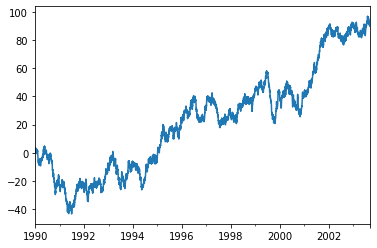

In [97]:
ts = pd.Series(np.random.randn(5000), index=pd.date_range("1/1/1990", periods=5000))

ts = ts.cumsum()

ts.plot();

In [98]:
plt.show();

<Figure size 432x288 with 0 Axes>

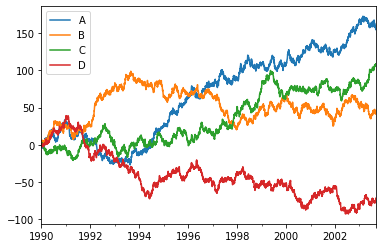

In [99]:
df = pd.DataFrame(
    np.random.randn(5000, 4), index=ts.index, columns=["A", "B", "C", "D"]
)

df = df.cumsum()

plt.figure();

df.plot();

plt.legend(loc='best');

##Importing and exporting data
**CSV**
Writing to a CSV file: using `DataFrame.to_csv()`:

In [100]:
df.to_csv("foo.csv")

Reading from a csv file: using `read_csv()`

In [101]:
pd.read_csv("foo.csv")

,Unnamed: 0,A,B,C,D
0,1990-01-01,-0.009426,0.517808,-0.747262,0.452550
1,1990-01-02,-0.433673,-0.684079,-1.126025,0.542003
2,1990-01-03,-0.068752,0.180176,-1.453727,0.817708
3,1990-01-04,-1.563770,1.084988,-1.425833,-0.630123
4,1990-01-05,-2.252135,2.575298,0.587233,-0.387071
...,...,...,...,...,...
4995,2003-09-05,155.296252,41.807868,108.047427,-73.435562
4996,2003-09-06,154.690891,42.195883,108.775597,-72.077137
4997,2003-09-07,154.324009,43.030764,108.823920,-71.542923
4998,2003-09-08,156.299145,42.493153,108.963972,-73.631561


**HDF5**

Reading and writing to HDFStores.

Writing to a HDF5 Store using `DataFrame.to_hdf()`:

In [102]:
df.to_hdf("foo.h5", "df")

Reading to a HDF5 Store using `read_hdf():`:

In [103]:
pd.read_hdf("foo.h5", "df")

,A,B,C,D
1990-01-01,-0.009426,0.517808,-0.747262,0.452550
1990-01-02,-0.433673,-0.684079,-1.126025,0.542003
1990-01-03,-0.068752,0.180176,-1.453727,0.817708
1990-01-04,-1.563770,1.084988,-1.425833,-0.630123
1990-01-05,-2.252135,2.575298,0.587233,-0.387071
...,...,...,...,...
2003-09-05,155.296252,41.807868,108.047427,-73.435562
2003-09-06,154.690891,42.195883,108.775597,-72.077137
2003-09-07,154.324009,43.030764,108.823920,-71.542923
2003-09-08,156.299145,42.493153,108.963972,-73.631561


##Excel

Reading & writing to Excel.

Writing to an excel file using `DataFrame.to_excel()`:

In [104]:
df.to_excel("foo.xlsx", sheet_name="Sheet1")

In [105]:
pd.read_excel("foo.xlsx", "Sheet1", index_col=None, na_values=["NA"])

,Unnamed: 0,A,B,C,D
0,1990-01-01,-0.009426,0.517808,-0.747262,0.452550
1,1990-01-02,-0.433673,-0.684079,-1.126025,0.542003
2,1990-01-03,-0.068752,0.180176,-1.453727,0.817708
3,1990-01-04,-1.563770,1.084988,-1.425833,-0.630123
4,1990-01-05,-2.252135,2.575298,0.587233,-0.387071
...,...,...,...,...,...
4995,2003-09-05,155.296252,41.807868,108.047427,-73.435562
4996,2003-09-06,154.690891,42.195883,108.775597,-72.077137
4997,2003-09-07,154.324009,43.030764,108.823920,-71.542923
4998,2003-09-08,156.299145,42.493153,108.963972,-73.631561


##Series
a one-dimensional labeled array capable of holding any data type(integers, strings, ..etc)

`s = pd.Series(data, index=index)`


###**From ndarray**

If `data` is an ndarray, index must be the same length as data. If no index is passed, one will be created having values `[0, ..., len(data) - 1]`.

In [106]:
# From ndarray
s = pd.Series(np.random.randn(5), index=["a", "b", "c", "d", "e"])
s

a   -0.531220
b    0.688921
c    0.779421
d   -0.091830
e   -0.339642
dtype: float64

In [107]:
s.index

Index(['a', 'b', 'c', 'd', 'e'], dtype='object')

In [108]:
pd.Series(np.random.randn(5))

0    0.219547
1   -1.002673
2   -0.365243
3   -2.014255
4    0.598338
dtype: float64

**From dict**
`Series` can be instantiated from dicts:

In [109]:
d = {"d":1, "a": 0, "c": 2}
pd.Series(d)

d    1
a    0
c    2
dtype: int64

In [110]:
# If an index is passed, the values in data corresponding to the labels in the index will be returned:

d = {"a": 0.0, "b": 1.0, "c": 2.0}

pd.Series(d)

a    0.0
b    1.0
c    2.0
dtype: float64

In [111]:
pd.Series(d, index=["b", "c", "d", "a"])

b    1.0
c    2.0
d    NaN
a    0.0
dtype: float64

**From scalar value**

If `data` is a scalar value, an index must be provided. The value will be repeated to match the length of the index.

In [112]:
pd.Series( '5a', index=["a", "b", "c", "d", "e"])

a    5a
b    5a
c    5a
d    5a
e    5a
dtype: object

In [113]:
s[s>s.median()]

b    0.688921
c    0.779421
dtype: float64

In [114]:

import openpyxl
import xlrd
pd.read_excel("/content/drive/MyDrive/Colab Notebooks/infra_data/Salient_cement_stats.xls")

,TABLE 1,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,"SALIENT CEMENT STATISTICS1, 2",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,(Thousand metric tons unless otherwise specified),NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,2014.0,2015.0,2016.0,2017.0,2018.0
5,United States:,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Production:,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Cement3,NaN,NaN,82535.0,84405.0,84695.0,86356.0,86400.0
8,Clinker,NaN,NaN,74372.0,76043.0,75633.0,76678.0,77112.0
9,"Shipments from mills and terminals:3, 4",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [115]:
def cfun(x):
    return int(x) if x else -1
    
pd.read_excel("/content/drive/MyDrive/Colab Notebooks/infra_data/release.xlsx", "Table1", usecols="A,B:G", converters={"MyInts": cfun})

,"Table 1. Value of Construction Put in Place in the United States, Seasonally Adjusted Annual Rate",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,(Millions of dollars. Details may not add to t...,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Type of Construction\n,Jan\n2023p,Dec\n2022r,Nov\n2022r,Oct\n2022,Sep\n2022,Jan\n2022
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
72,"lodging, religious, communication, and manufac...",NaN,NaN,NaN,NaN,NaN,NaN
73,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,"Data are at an annual rate, adjusted for seaso...",NaN,NaN,NaN,NaN,NaN,NaN
75,Table 3 provides estimated measures of samplin...,NaN,NaN,NaN,NaN,NaN,NaN


In [118]:
bb = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/infra_data/release1.xlsx", "Sheet1", dtype={"MyInts": "Int64Dtype()", "MyText": str})
bb

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Percent change\nJan 2023 from -,Unnamed: 8
0,Type of Construction\n,Jan\n2023p,Dec\n2022r,Nov\n2022r,Oct\n2022,Sep\n2022,Jan\n2022,Dec\n2022,Jan\n2022
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Total Construction,1825653,1827535,1840294,1808343,1807497,1726585,-0.1,5.7
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Residential,856912,861674,869322,874105,889018,890763,-0.6,-3.8
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Nonresidential,968741,965861,970972,934238,918479,835822,0.3,15.9
7,Lodging,21930,21745,21774,21845,20144,15699,0.9,39.7
8,Office,96022,95315,95292,89874,87310,84401,0.7,13.8
9,Commercial,125503,129564,129822,125866,120099,102782,-3.1,22.1


In [117]:
bb[bb.columns[:9]].dtypes

Table 1. Value of Construction Put in Place in the United States, Seasonally Adjusted Annual Rate    object
Unnamed: 1                                                                                           object
Unnamed: 2                                                                                           object
Unnamed: 3                                                                                           object
Unnamed: 4                                                                                           object
Unnamed: 5                                                                                           object
Unnamed: 6                                                                                           object
Unnamed: 7                                                                                           object
Unnamed: 8                                                                                           object
dtype: object